In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numba import jit


In [2]:
@jit(nopython=True)
def neighbors(point, size):
    return [((point[0]+1)%size, point[1]),
            ((point[0]-1)%size, point[1]),
            (point[0], (point[1]+1)%size),
            (point[0], (point[1]-1)%size),]

In [3]:
@jit(nopython=True)
def fast_de_old(img, start, end):
    size = img.shape[0]
    n0 = neighbors(start, size)
    n1 = neighbors(end, size)
    c0 = img[start[0], start[1]]
    c1 = img[end[0], end[1]]
    le0 = (np.sum([((img[pt]-c0)**2).sum() for pt in n0]) +
           np.sum([((img[pt]-c1)**2).sum() for pt in n1]))
    le1 = (np.sum([((img[pt]-c0)**2).sum() for pt in n1]) +
           np.sum([((img[pt]-c1)**2).sum() for pt in n0]))
    return le1 - le0

In [4]:
@jit(nopython=True)
def fast_de(img, start, end):
    size = img.shape[0]
    n0 = neighbors(start, size)
    n1 = neighbors(end, size)
    c0 = img[start[0], start[1]]
    c1 = img[end[0], end[1]]
    le0 = 0.
    for i in range(4):
        le0 += ((img[n0[i]]-c0)**2).sum()
    for i in range(4):
        le0 += ((img[n1[i]]-c1)**2).sum()
    le1 = 0.
    for i in range(4):
        le1 += ((img[n1[i]]-c0)**2).sum()
    for i in range(4):
        le1 += ((img[n0[i]]-c1)**2).sum()
    return le1 - le0

In [5]:
import matplotlib as mpl
def show(im_data, SCALE=32):

    dpi = mpl.rcParams['figure.dpi'] / SCALE
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray', interpolation='nearest')

    plt.show()

In [6]:
bits = 6
assert bits % 6 == 0
size = 2**(bits//2)
cmax = 2**(bits//3)

img = np.zeros((size, size, 3))
for i in range(size):
    for j in range(size):
        n = i*size + j
        for c in range(3):
            img[i, j, c] = (n % cmax) / (cmax - 1.)
            n = n // cmax
        

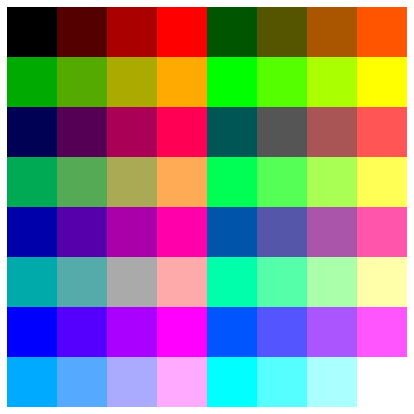

In [7]:
show(img, max(400//size, 1))

In [8]:
np.exp(-4)

0.01831563888873418

In [9]:
np.random.randint(-1,2,(50))

array([ 0,  1,  0, -1, -1,  0,  1,  0,  1,  0, -1,  1,  0, -1,  1,  0,  1,
       -1,  1, -1,  0,  1,  1, -1,  0, -1,  1,  1, -1, -1,  1,  1, -1, -1,
        0, -1, -1,  0, -1, -1, -1,  0,  1, -1, -1,  1, -1,  0,  1, -1])

In [14]:
offset, bigstep

(100, 99)

In [17]:
@jit(nopython=True)
def run(nsteps, img, offset):
    
    pool = np.random.randint(0, size, (nsteps, 2, 2))
    pool2 = np.random.random(nsteps)
    #pool3 = np.random.randint(-1, 2, (nsteps, 1, 2))
    
    #diffx = img[:-1, :, :] - img[1:, :, :]
    #diffy = img[:, :-1, :] - img[:, 1:, :]
    #e0 = ((diffx**2).sum() + (diffy**2).sum())
    
    for step in range(nsteps):

        start = pool[step, 0]
        #end = (start + pool3[step, 0]) % size
        end = pool[step, 1]
        de = fast_de(img, start, end)
        
        T = 1. * np.exp(-6 * (offset + step / nsteps)/100)
        
        #T = (((start+end)/(2*size))**2).sum() * .2

        
        temp = img[start[0], start[1]].copy()
        img[start[0], start[1]] = img[end[0], end[1]]
        img[end[0], end[1]] = temp
        
            
        #diffx = img[:-1, :, :] - img[1:, :, :]
        #diffy = img[:, :-1, :] - img[:, 1:, :]
        #e1 = ((diffx**2).sum() + (diffy**2).sum())
        
        #de = e1 - e0
        if (de < 0) or (T > 0. and (pool2[step] < np.exp(-de / T))):
            # e0 = e1
            pass
        else:
            img[end[0], end[1]] = img[start[0], start[1]]
            img[start[0], start[1]] = temp    

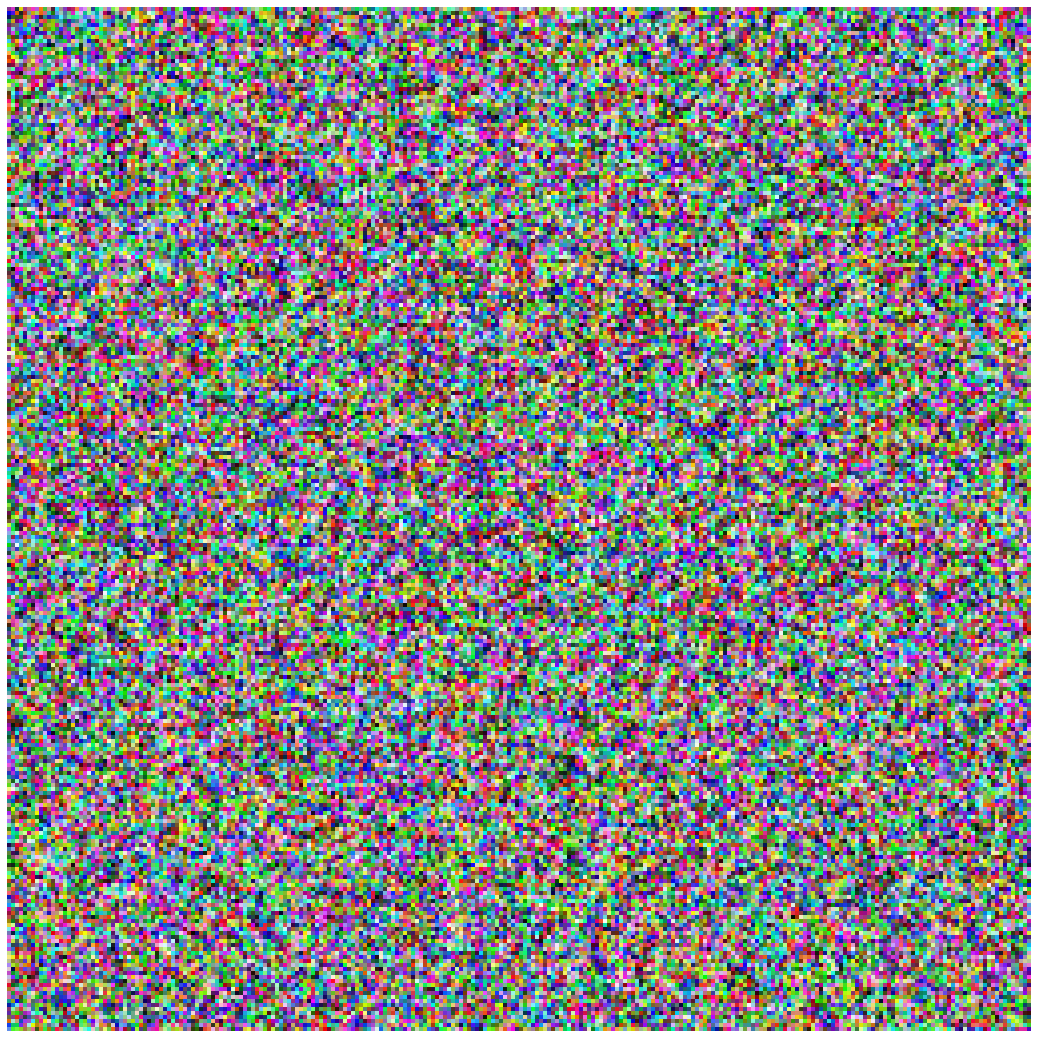

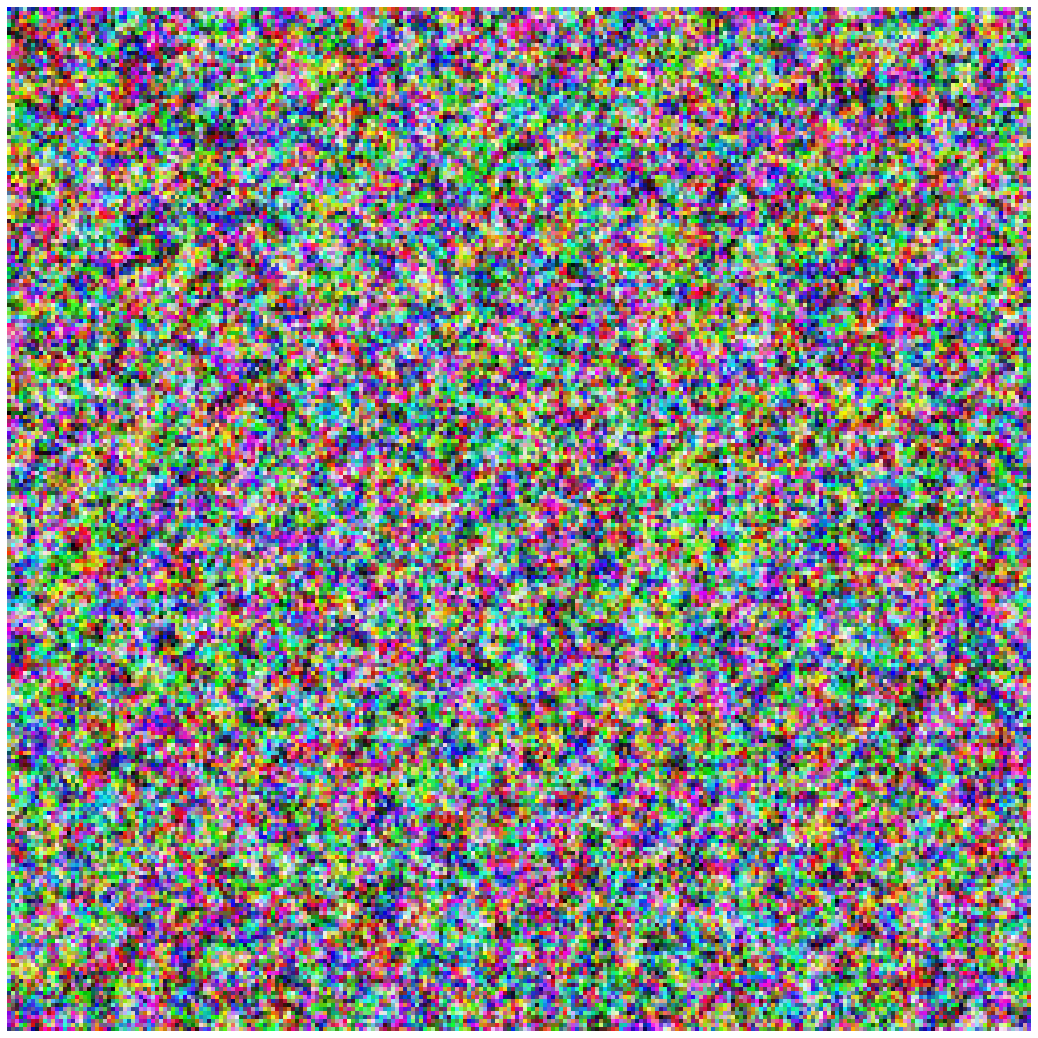

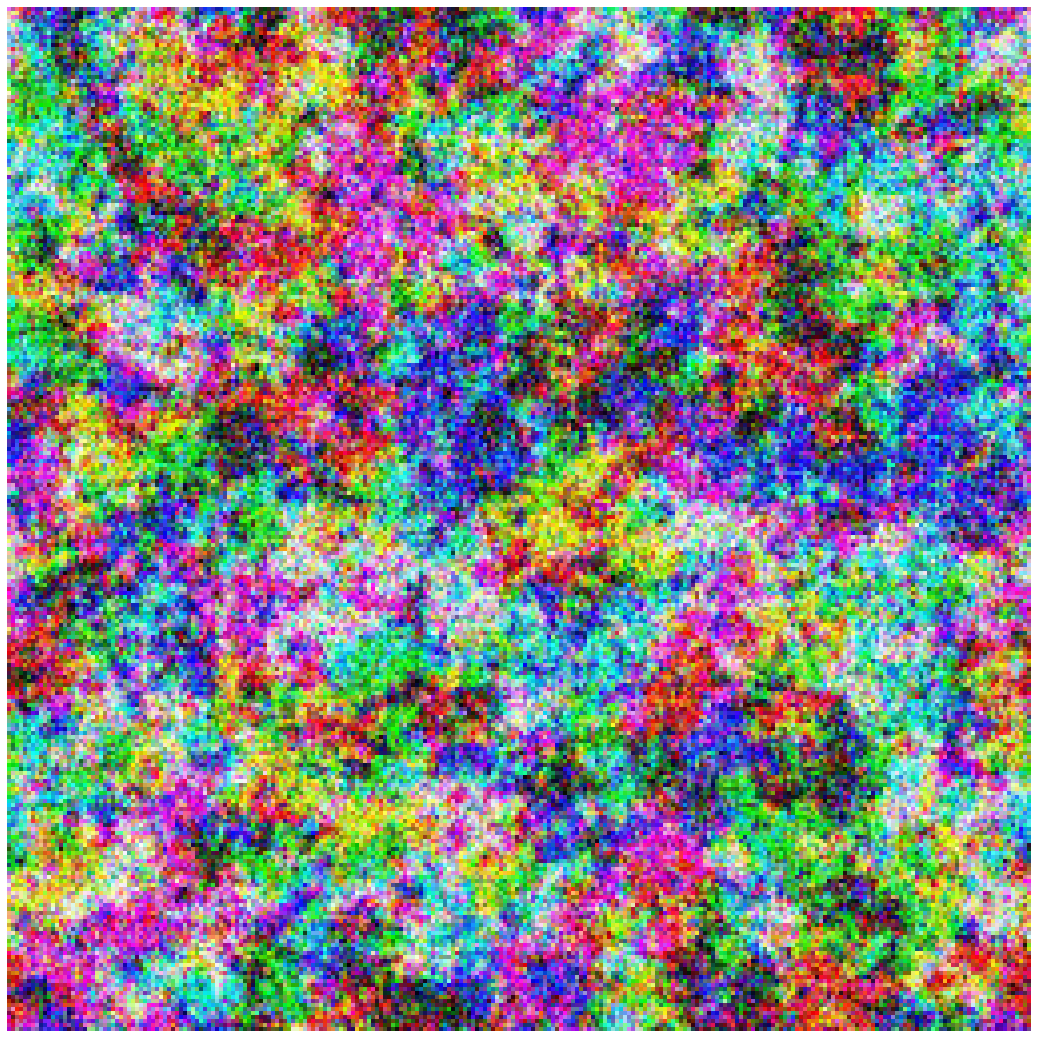

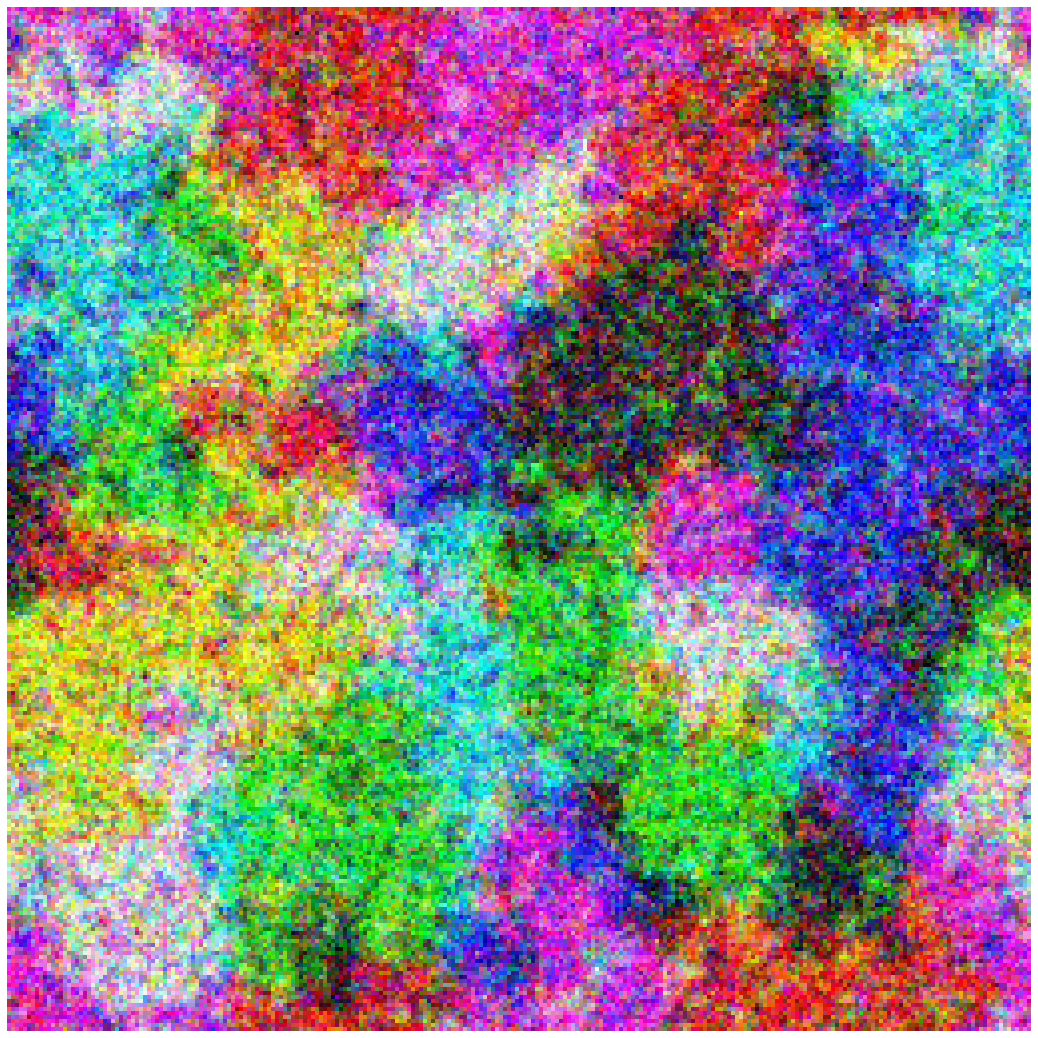

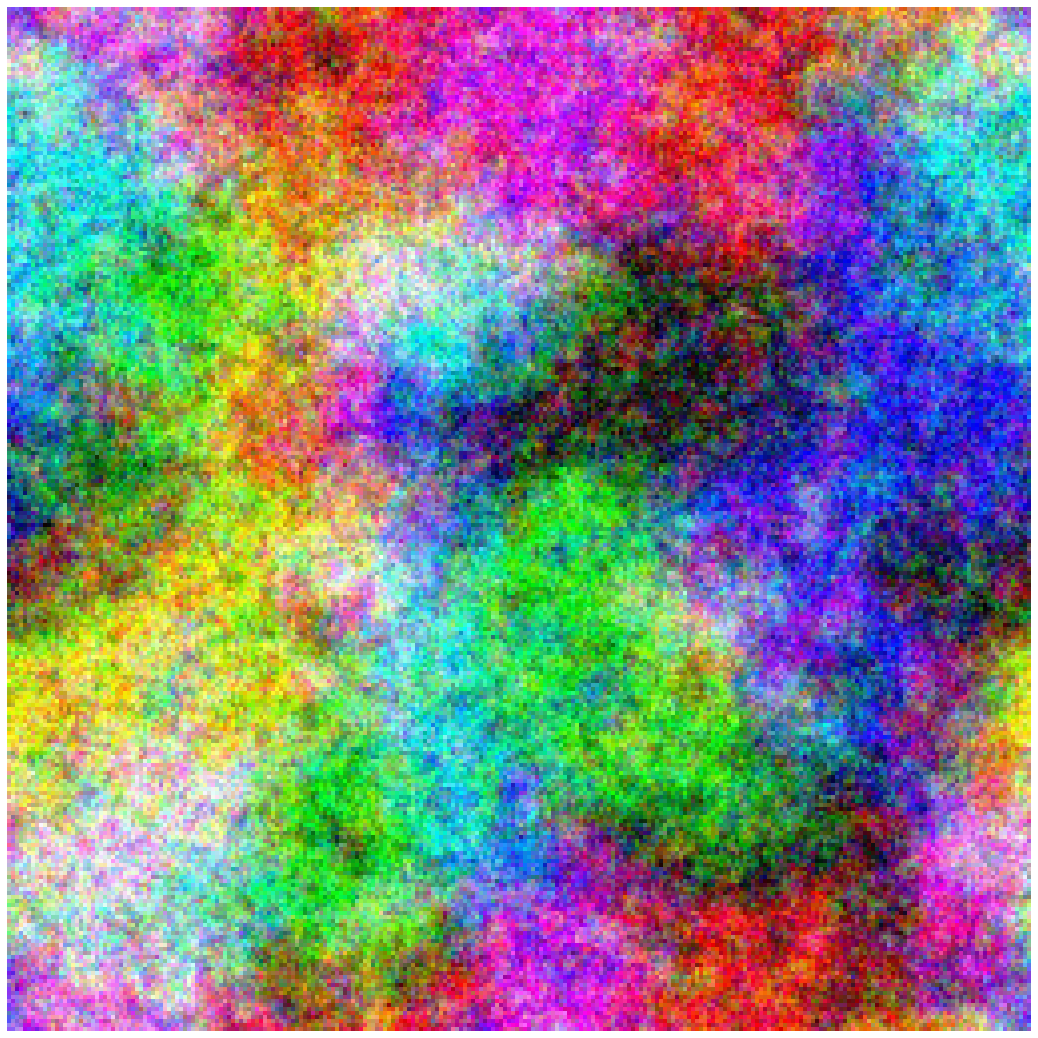

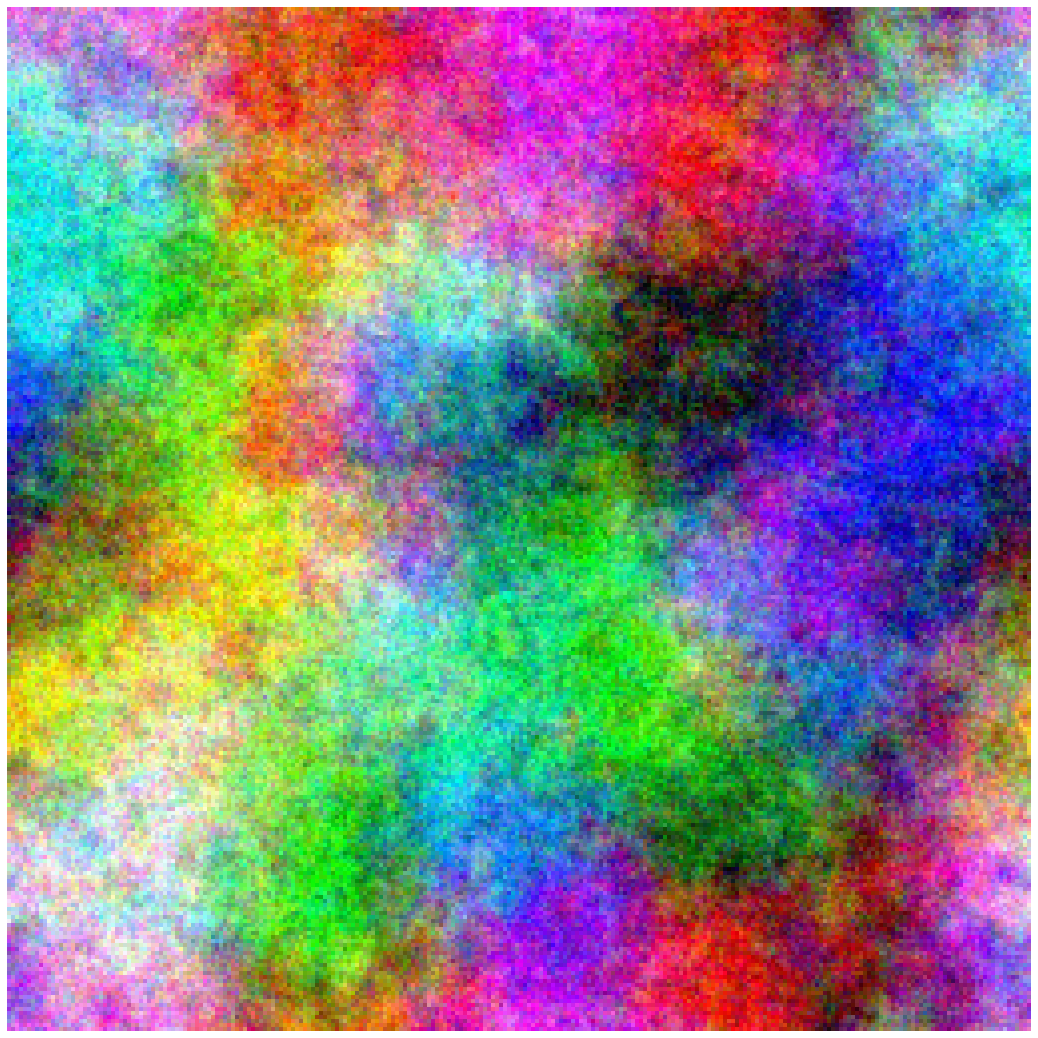

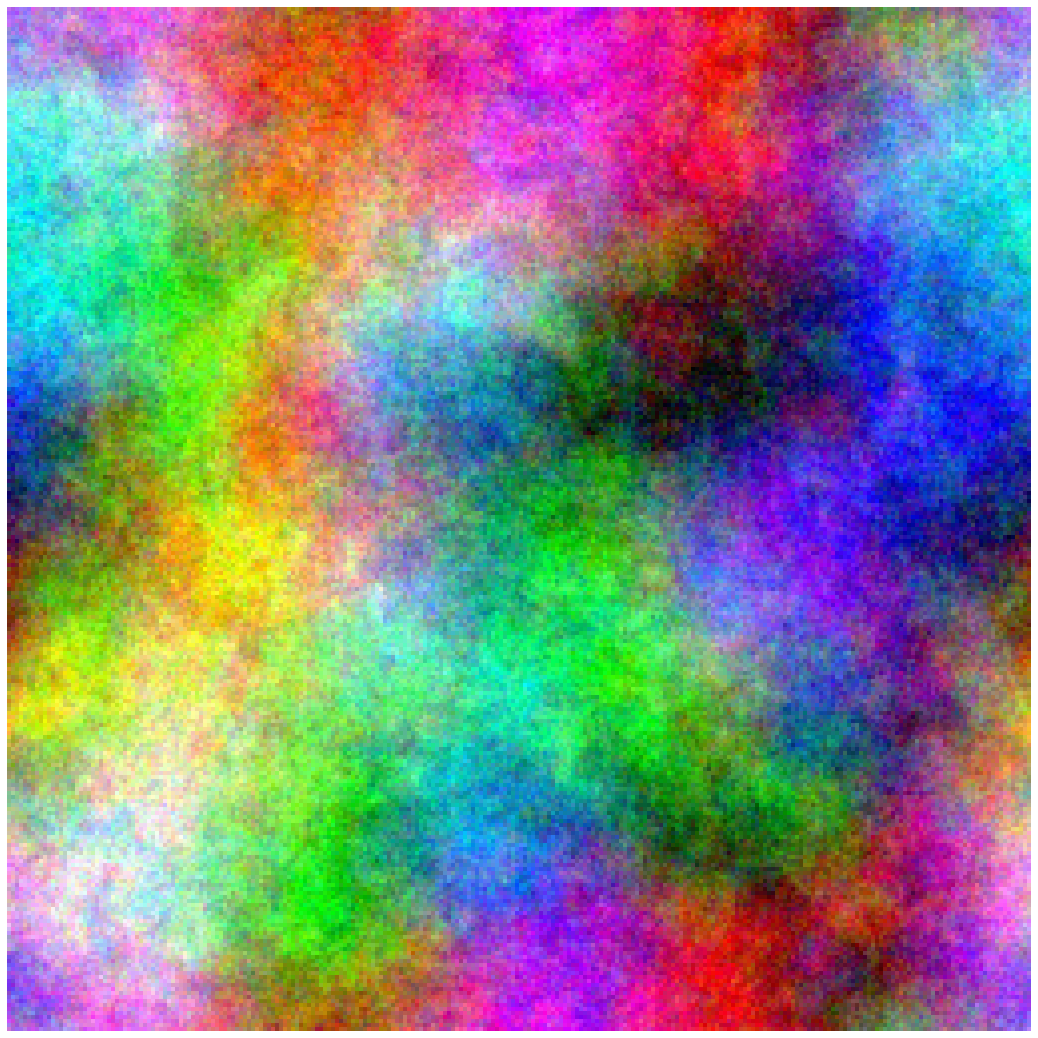

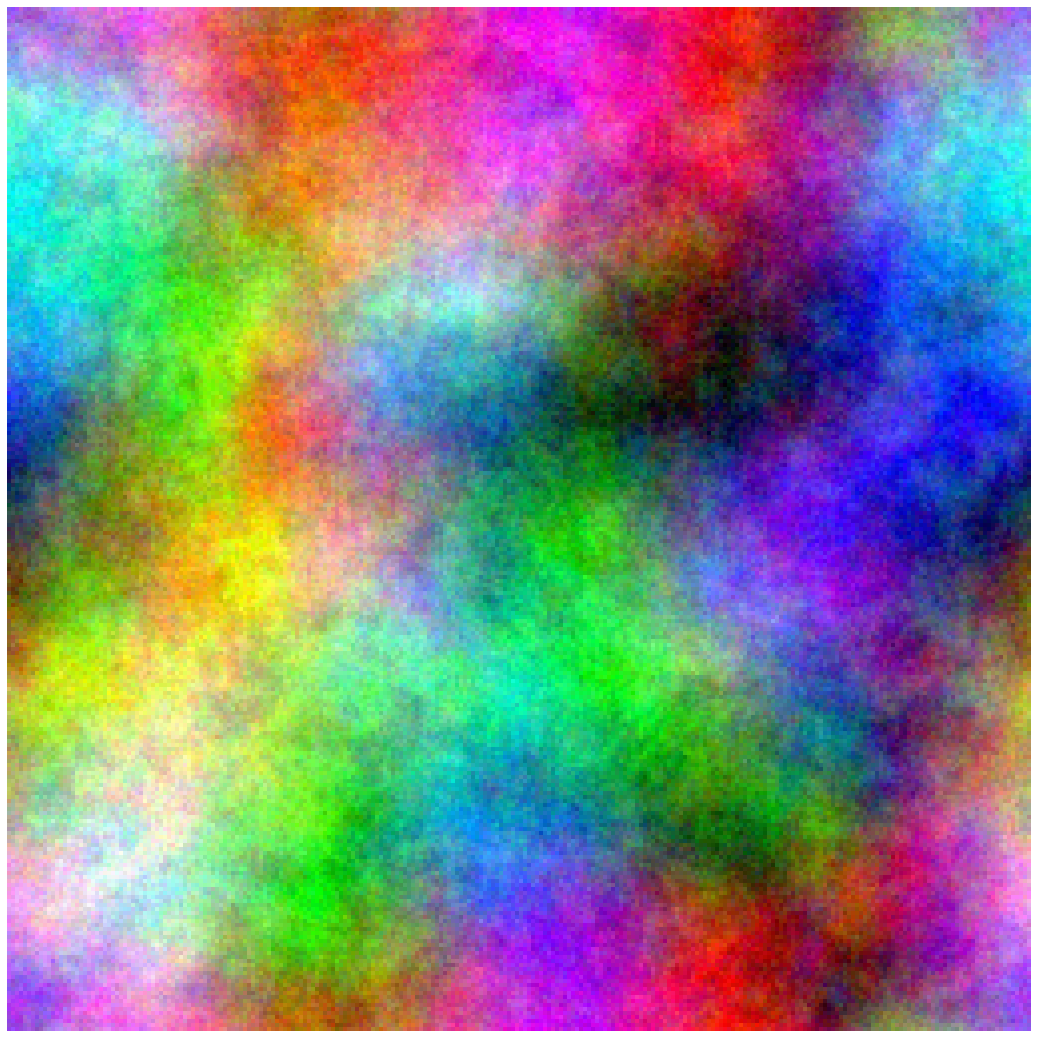

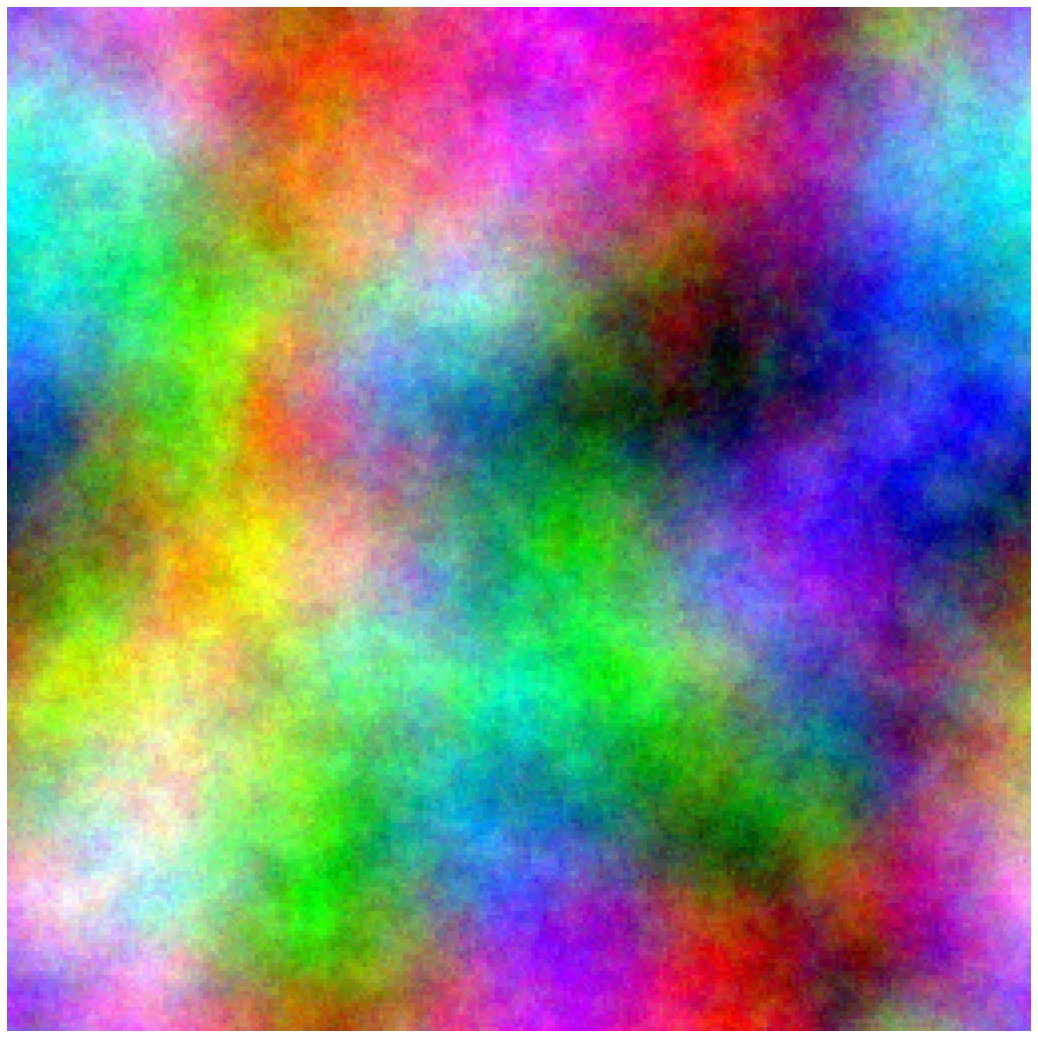

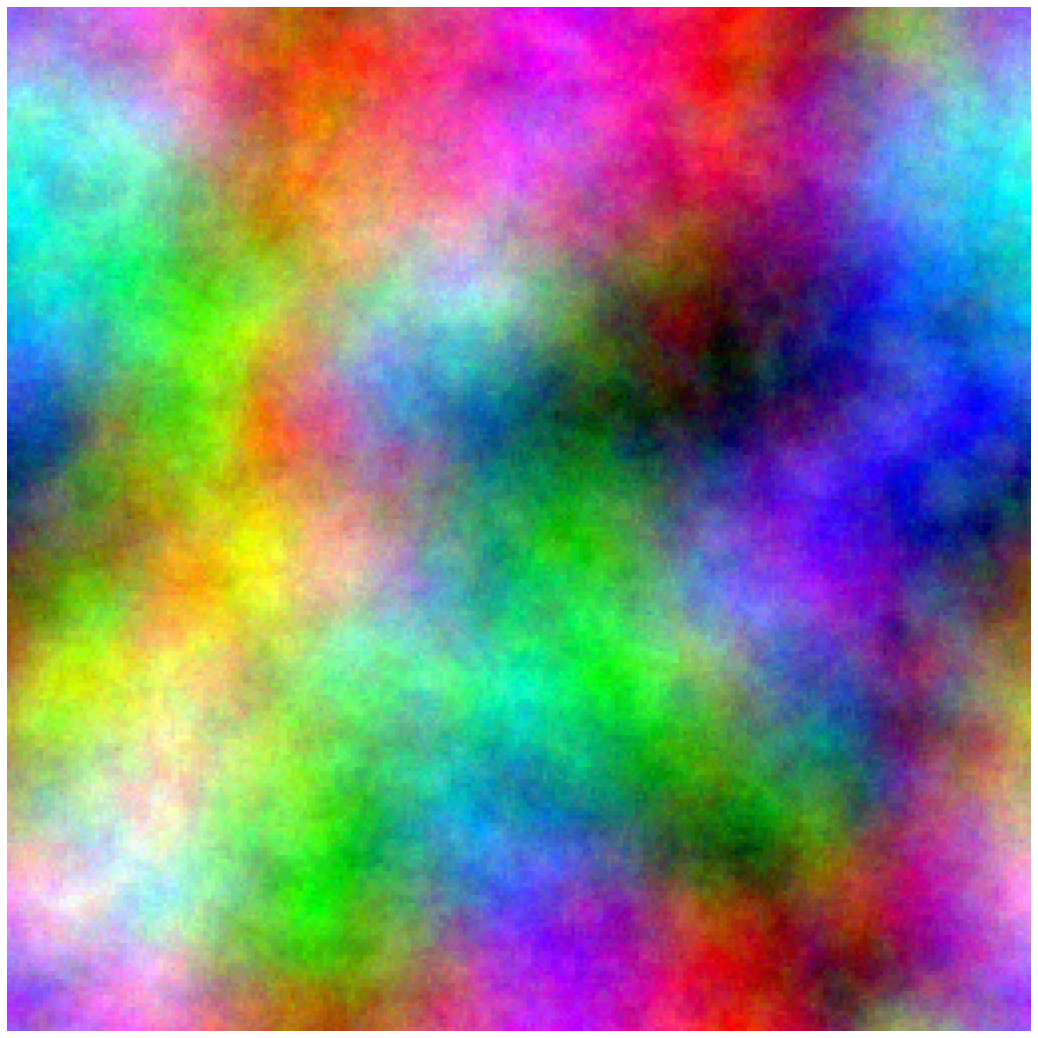

CPU times: user 5h 2min 32s, sys: 1min 57s, total: 5h 4min 30s
Wall time: 5h 3min 46s


In [18]:
%%time

size = 256
img = np.random.random((size, size, 3))

nsteps = 100_000_000

offset = 0
for bigstep in range(100):
    run(nsteps, img, offset)
    offset += 1
    if bigstep % 10 == 0:
        show(img, 4)

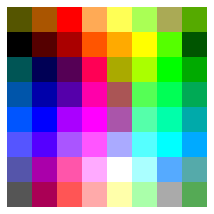

In [150]:
show(img, 200//size)

In [ ]:
%%time

@jit(nopython=True)
def run(nsteps, img):
    
    pool = np.random.randint(0, size, (nsteps, 2, 2))
    pool2 = np.random.random(nsteps)
    
    #diffx = img[:-1, :, :] - img[1:, :, :]
    #diffy = img[:, :-1, :] - img[:, 1:, :]
    #e0 = ((diffx**2).sum() + (diffy**2).sum())
    
    for step in range(nsteps):

        start = pool[step, 0]
        end = pool[step, 1]
        de = fast_de(img, start, end)
        
        T = 1. * np.exp(-4 * step / nsteps)
        
        #T = (((start+end)/(2*size))**2).sum() * .2

        
        temp = img[start[0], start[1]].copy()
        img[start[0], start[1]] = img[end[0], end[1]]
        img[end[0], end[1]] = temp
        
            
        #diffx = img[:-1, :, :] - img[1:, :, :]
        #diffy = img[:, :-1, :] - img[:, 1:, :]
        #e1 = ((diffx**2).sum() + (diffy**2).sum())
        
        #de = e1 - e0
        if (de < 0) or (T > 0. and (pool2[step] < np.exp(-de / T))):
            # e0 = e1
            pass
        else:
            img[end[0], end[1]] = img[start[0], start[1]]
            img[start[0], start[1]] = temp
        

#size = 200
#img = np.random.random((size, size, 3))
nsteps = 100_000_000

run(nsteps, img)

show(img, 1)
    

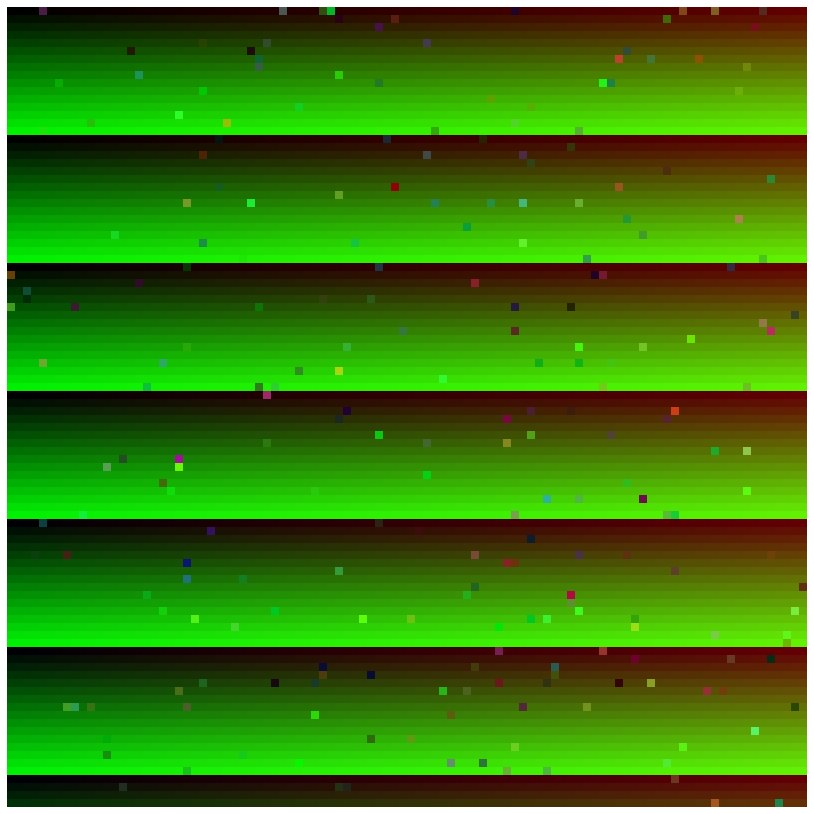

In [132]:
show(img[:100,:100], 8)

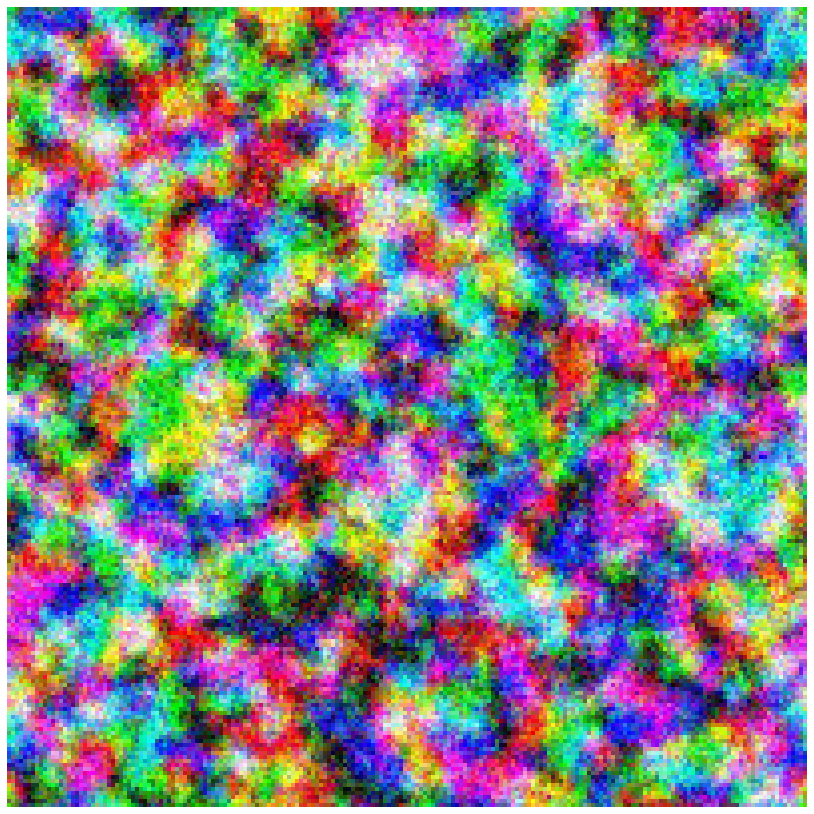

In [92]:
show(img, 4)

In [91]:
anneal[(size, nsteps, .3, 1)] = img

In [85]:
t03 = img

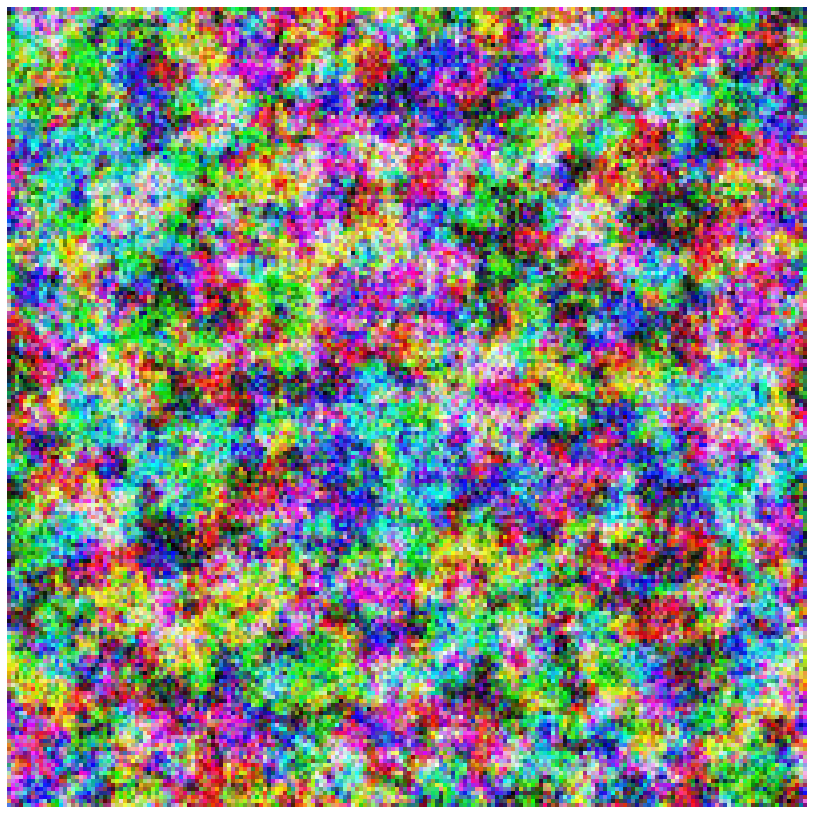

In [86]:
show(t03, 4)

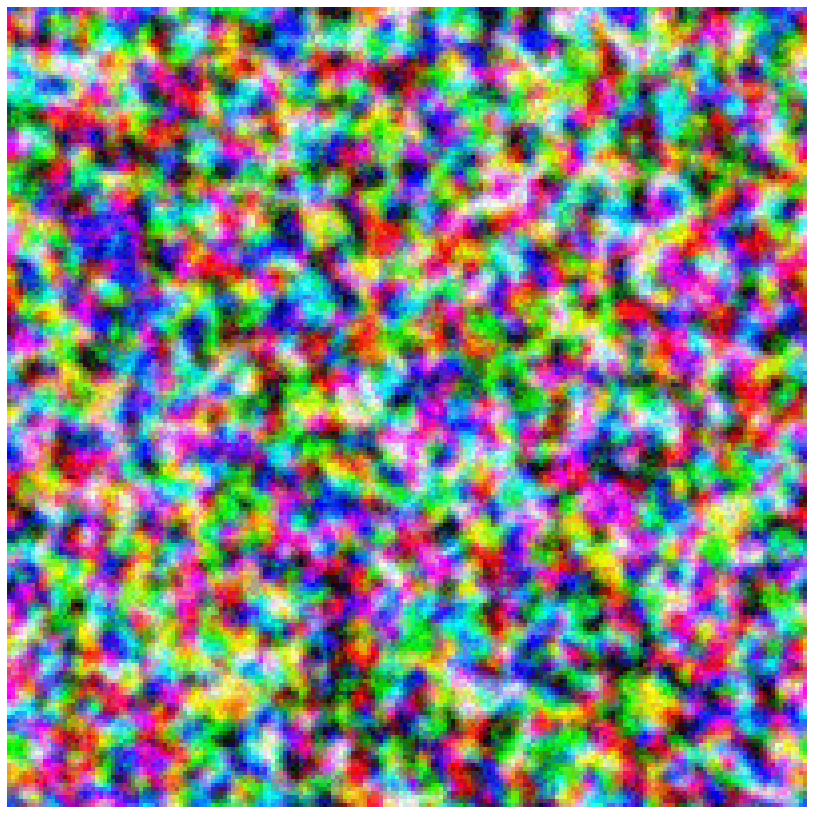

In [79]:
show(img, 4)

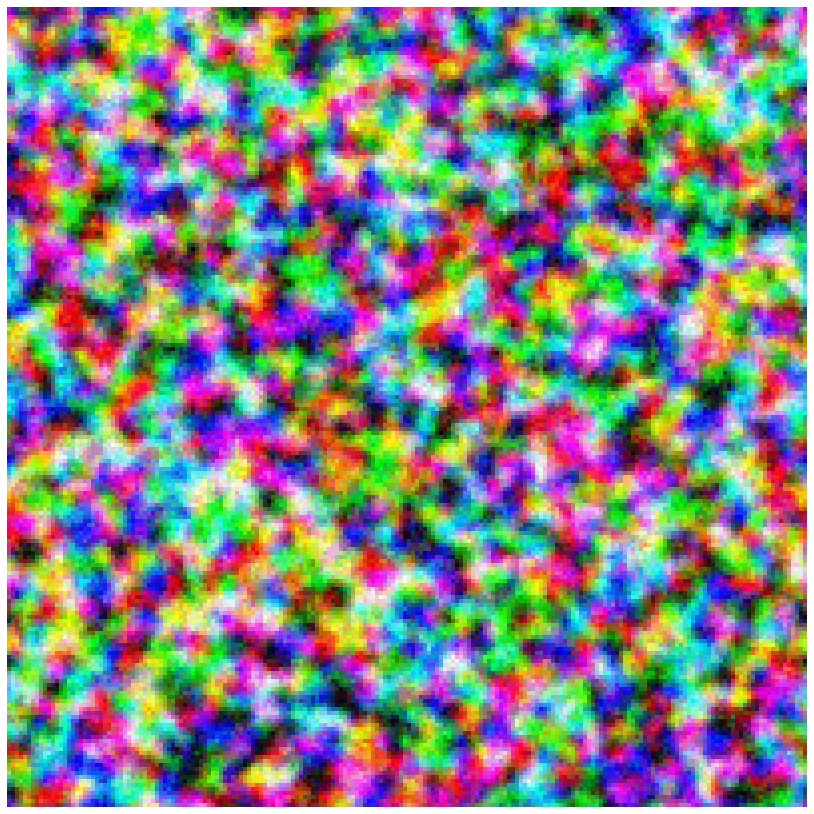

In [88]:
show(img, 4)

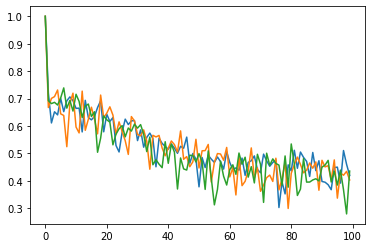

In [78]:
fft = np.fft.fft2(img, axes=(0,1))[:100,:100]
mag = np.log(np.abs(fft))
mag = mag - np.min(mag)
mag = mag / np.max(mag)
plt.plot(mag[0])
plt.show()

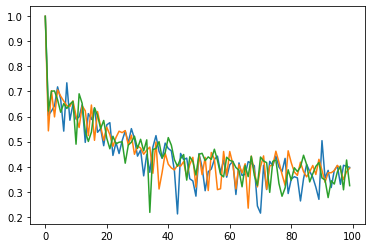

In [96]:
fft = np.fft.fft2(img, axes=(0,1))[:100,:100]
mag = np.log(np.abs(fft))
mag = mag - np.min(mag)
mag = mag / np.max(mag)
plt.plot(mag[0])
plt.show()

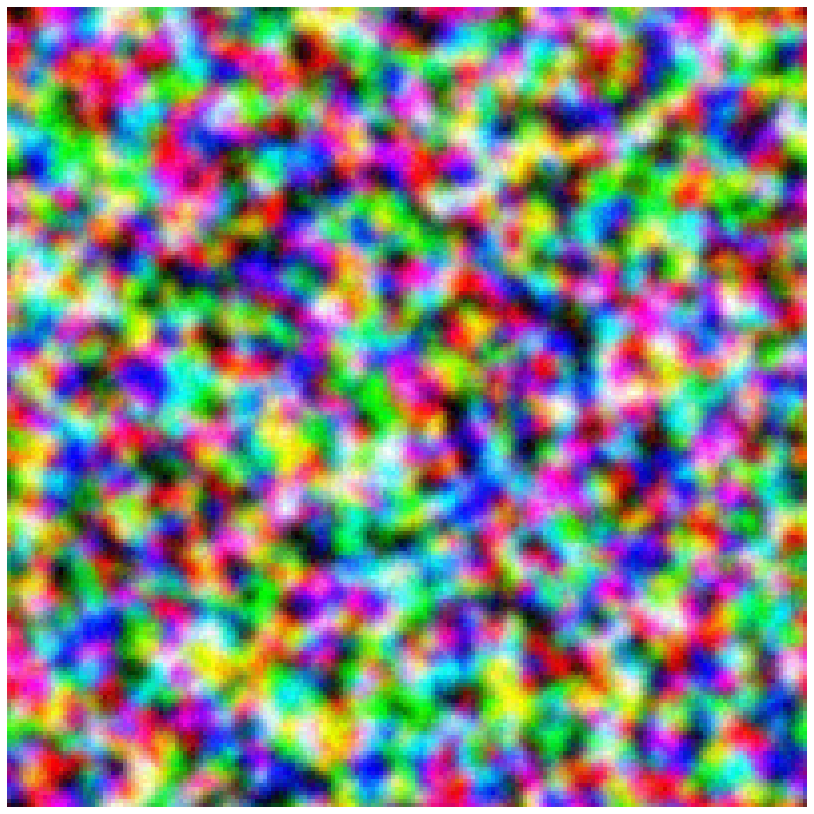

In [51]:
show(img, 4)

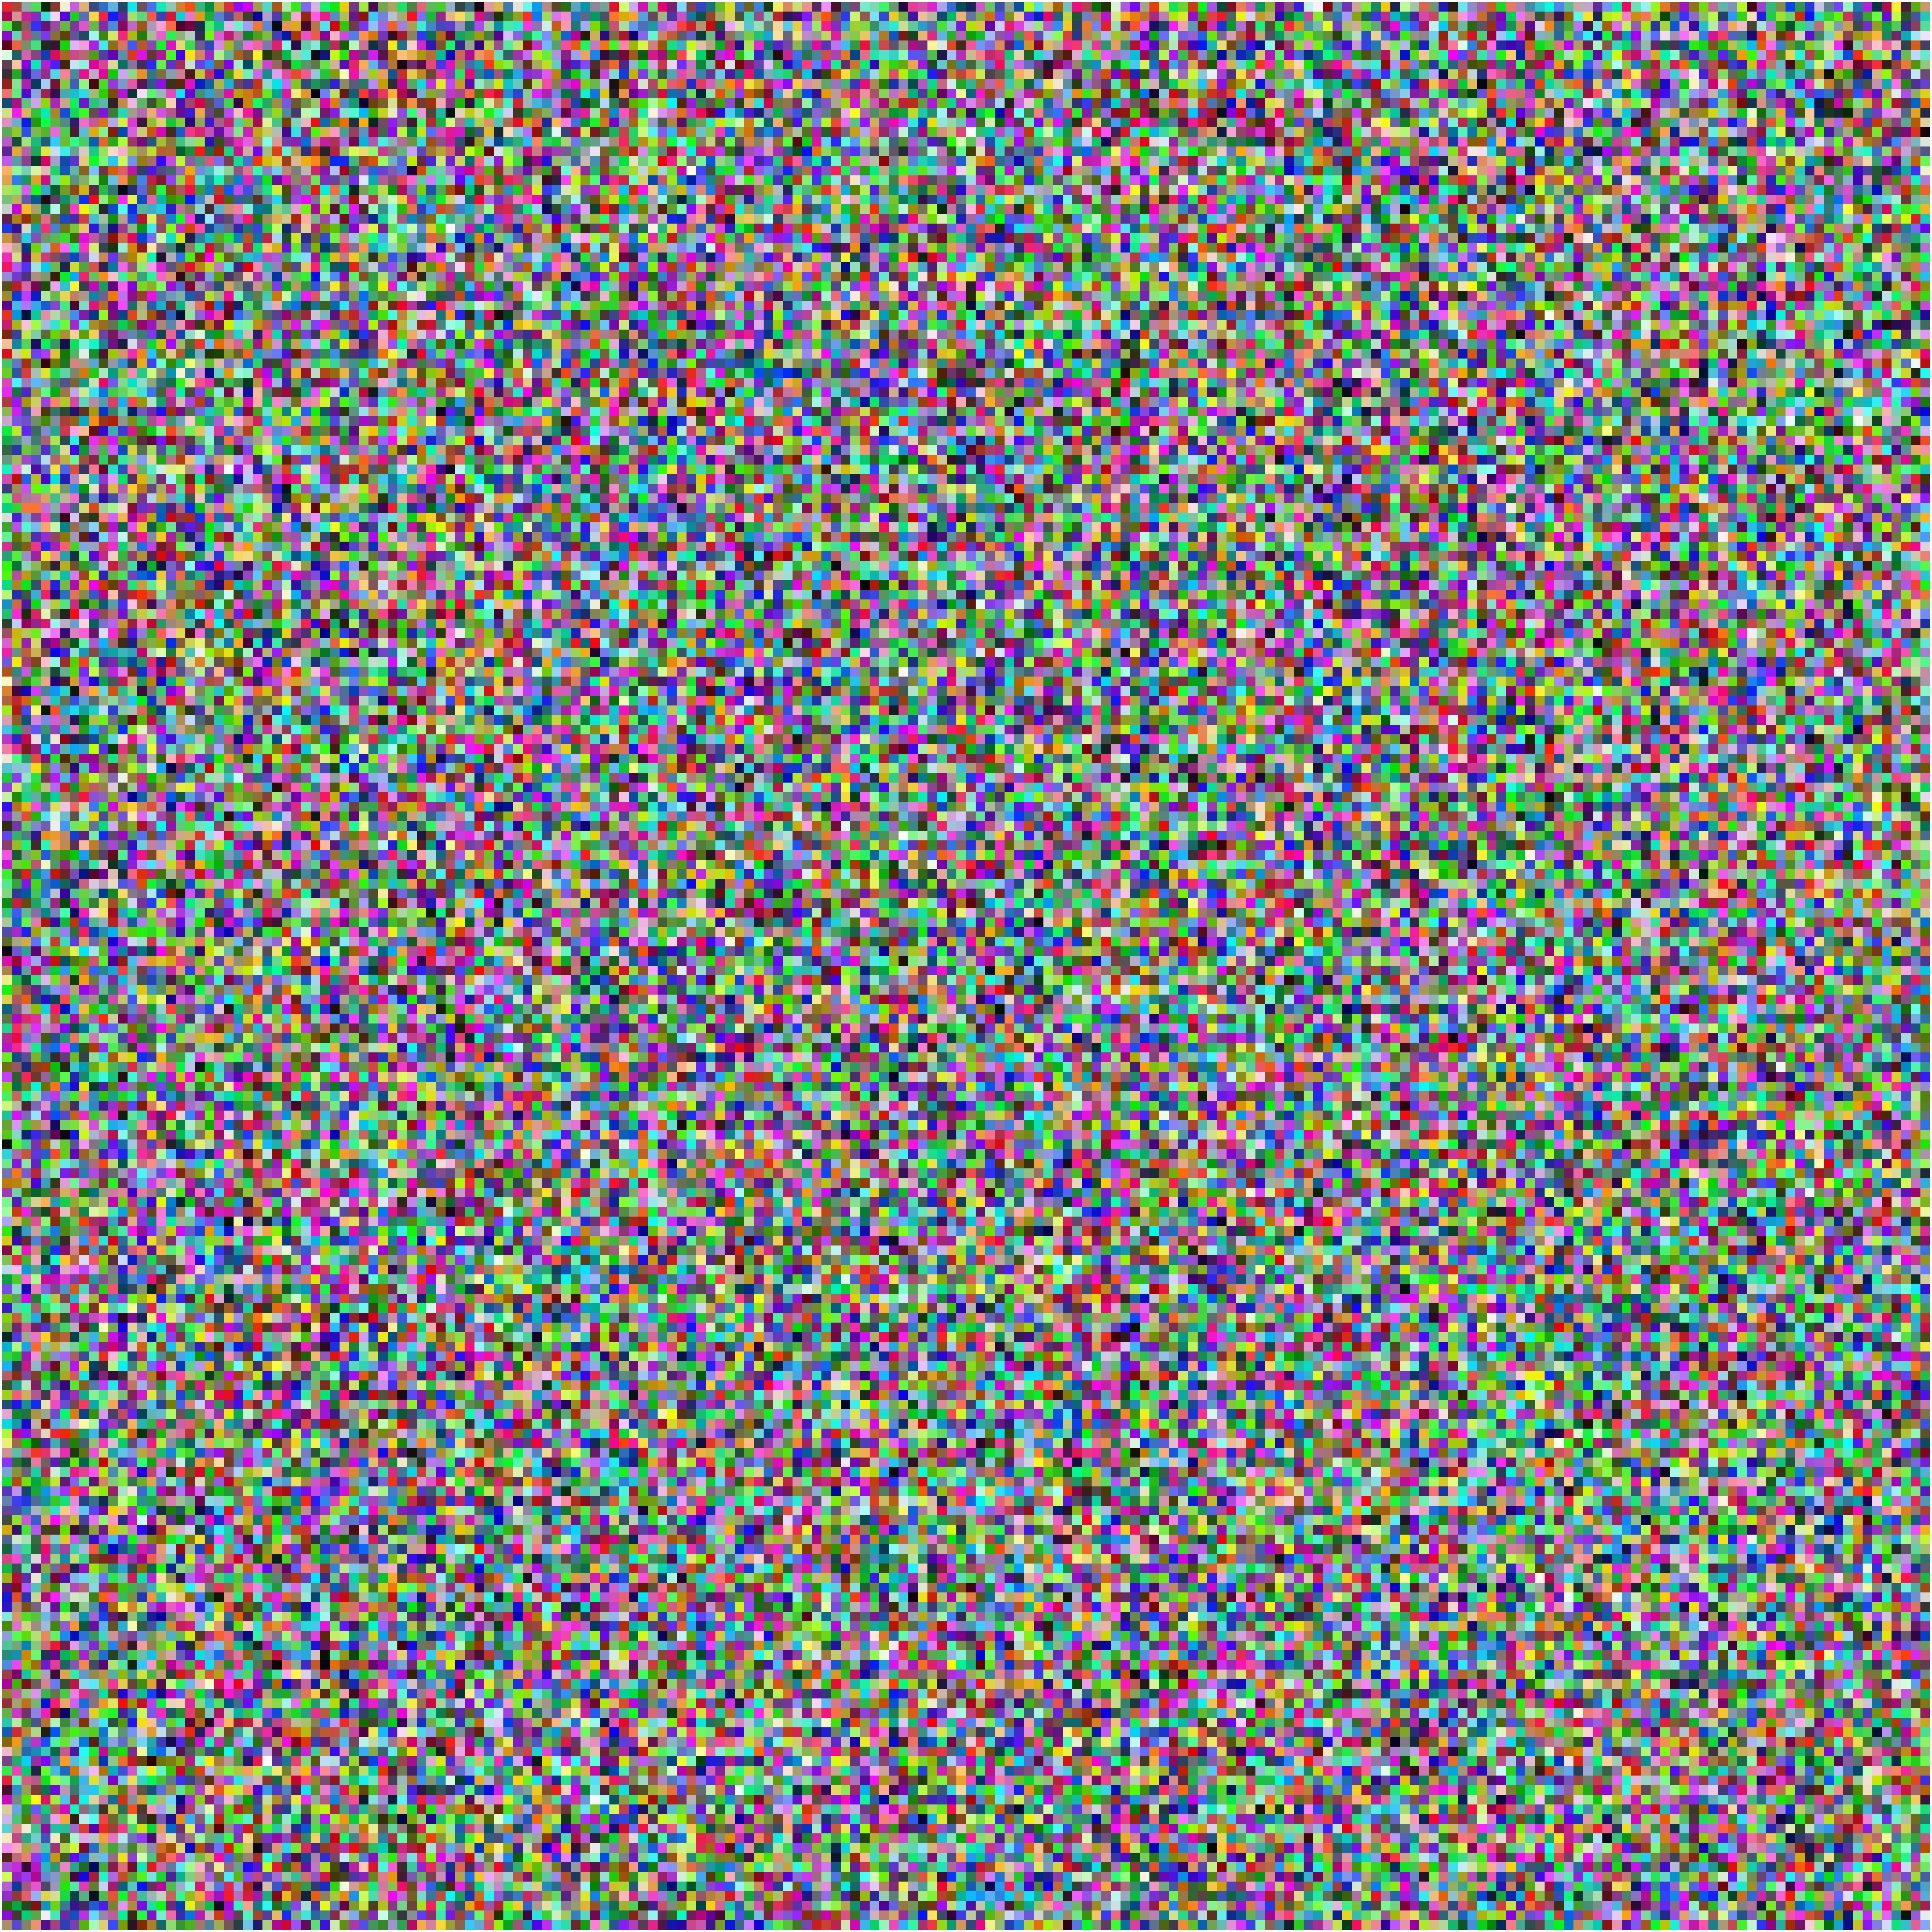

In [39]:
size = 200
img2 = np.random.random((size, size, 3))


show(img2, 30)

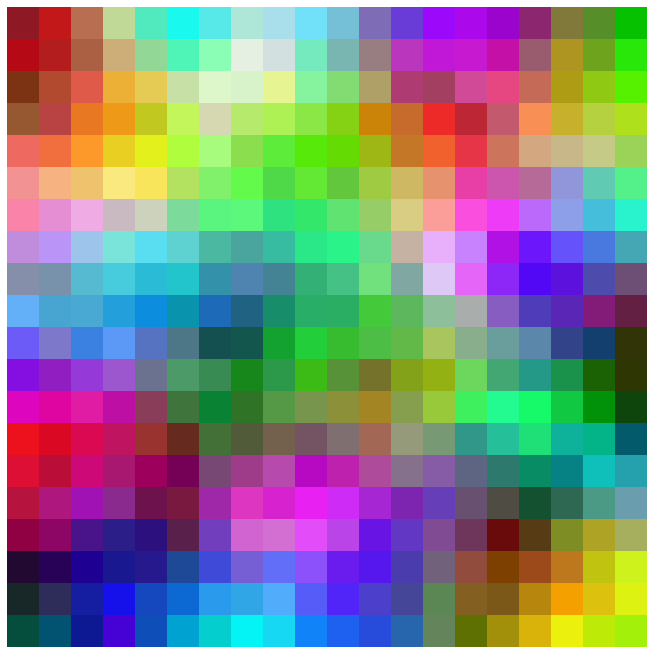

In [205]:
e0 = energy(img)
for step in range(100_000):
    start = tuple(np.random.randint(0, size, 2))
    end = tuple(np.random.randint(0, size, 2))
    img2 = img.copy()
    img2[start] = img[end]
    img2[end] = img[start]
    e1 = energy(img2)
    if e1 < e0:
        img = img2
        e0 = e1
    else:
        p_acc = 0 * np.exp((e0 - e1) / 10.)
        if np.random.random(1) < p_acc:
            img = img2
            e0 = e1

show(img)
        
    

In [109]:
img[start]

array([0.20911954, 0.94672207, 0.75215771])